In [5]:
pip install pmdarima

     |████████████████████████████████| 481kB 3.1MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
%matplotlib inline
# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [37]:
timeSeries = pd.read_csv('time_series.csv')
timeSeries= timeSeries[[ 'Dates', 'NbrQual', 'NbrNonQual']]
timeSeries.head()

,Dates,NbrQual,NbrNonQual
0,2015-12-29,2,1
1,2015-12-30,2,1
2,2015-12-31,2,1
3,2016-01-01,3,1
4,2016-01-02,3,1


In [38]:
timeSeries['Dates'] = pd.to_datetime(timeSeries['Dates'])
timeSeries['week'] = timeSeries['Dates'].dt.week
timeSeries['year'] = timeSeries['Dates'].dt.year

In [39]:
timeSeries['year'].value_counts()

2016    366
2018    365
2017    363
2019    200
2015      3
Name: year, dtype: int64

In [42]:
#time prediction using time need to use recent data
timeSeries = timeSeries[timeSeries['year'] == 2019]
timeSeries['year'].value_counts()

2019    200
Name: year, dtype: int64

In [43]:
timeSeries = timeSeries[['Dates', 'NbrQual']]
timeSeries =timeSeries[timeSeries['Dates'] <  '2019-06-01'] 
timeSeries = timeSeries.set_index('Dates')

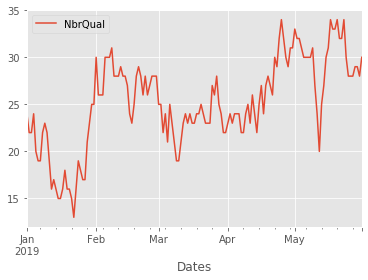

In [44]:
timeSeries.plot()

In [45]:
train = timeSeries.iloc[:140]
test = timeSeries.iloc[140:]

In [46]:
model = ARMA(train['NbrQual'],order=(2,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                NbrQual   No. Observations:                  140
Model:                     ARMA(2, 1)   Log Likelihood                -291.325
Method:                       css-mle   S.D. of innovations              1.926
Date:                Sun, 10 Nov 2019   AIC                            592.649
Time:                        16:22:44   BIC                            607.357
Sample:                    01-01-2019   HQIC                           598.626
                         - 05-20-2019                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            25.4520      1.900     13.397      0.000      21.729      29.175
ar.L1.NbrQual     0.0879      0.189      0.466      0.642      -0.282       0.458
ar.L2.NbrQual     0.7706      0.170      4.527      0.000       0.437       1.104
ma.L1.NbrQual     0.7722      0.209      3.695      0.000       0.363       1.182
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0835           +0.0000j            1.0835            0.0000
AR.2           -1.1976           +0.0000j            1.1976            0.5000
MA.1           -1.2950           +0.0000j            1.2950            0.5000
-----------------------------------------------------------------------------
"""

In [47]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end)

In [48]:
pred = predictions.to_frame().reset_index().rename(columns={'index':'Dates',0:'PredNbrQual'})
pred

,Dates,PredNbrQual
0,2019-05-21,33.464011
1,2019-05-22,32.743435
2,2019-05-23,32.267061
3,2019-05-24,31.669902
4,2019-05-25,31.250315
5,2019-05-26,30.753254
6,2019-05-27,30.386226
7,2019-05-28,29.970922
8,2019-05-29,29.651583
9,2019-05-30,29.303474


In [49]:
test=test.reset_index()
test

,Dates,NbrQual
0,2019-05-21,32
1,2019-05-22,32
2,2019-05-23,34
3,2019-05-24,30
4,2019-05-25,28
5,2019-05-26,28
6,2019-05-27,28
7,2019-05-28,29
8,2019-05-29,29
9,2019-05-30,28


In [50]:
new = test.merge(pred, on=['Dates'])
new

,Dates,NbrQual,PredNbrQual
0,2019-05-21,32,33.464011
1,2019-05-22,32,32.743435
2,2019-05-23,34,32.267061
3,2019-05-24,30,31.669902
4,2019-05-25,28,31.250315
5,2019-05-26,28,30.753254
6,2019-05-27,28,30.386226
7,2019-05-28,29,29.970922
8,2019-05-29,29,29.651583
9,2019-05-30,28,29.303474


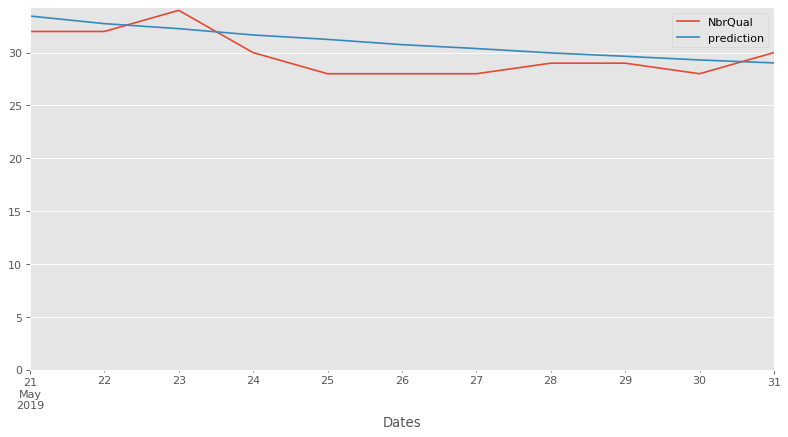

In [51]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.style.use('ggplot')
a = new.set_index('Dates')
ax = a['NbrQual'].plot()
ax2 = a['PredNbrQual'].plot(label = 'prediction')
ax.set_ylim(ymin=0)
plt.legend()
plt.show()

In [52]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test['NbrQual'], predictions)
print(f'ARIMA(1,1,1) MSE Error: {error:11.10}')

ARIMA(1,1,1) MSE Error: 3.303648698
